# __Image Classification Using CNN__

Let's see a working example of training a convolutional neural network (CNN) on a dataset of flower images.

## Steps to be followed:

1. Import the necessary libraries and dataset
2. Count and retrieve the images
3. Create a training dataset
4. Create a validation dataset
5. Visualize a subset of images from the training dataset
6. Preprocess and normalize the training dataset
7. Create a convolutional neural network model with data augmentation
8. Summarize and compile the model
9. Train the model
10. Visualize the result
11. Predict the class of a given image

### Step 1: Import the necessary libraries and dataset
- Import the required libraries.
- Import the given dataset using the link provided.
> NOTE1: Be sure you have the correct versions of the core libraries installed. I recommend **`pip install "tensorflow[and-cuda]==2.17.0" "numpy==1.26.4"`**


> NOTE2: As always, after installing new libraries or changing versions of libraries, restart your kernel to load those changes in your current notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

In [2]:
# Load the dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

# The dataset is already at the correct level - no need to go deeper
print(f"Data directory: {data_dir}")
print(f"Directory exists: {data_dir.exists()}")
print("\nContents of data directory:")
if data_dir.exists():
    for item in data_dir.iterdir():
        if item.name != 'LICENSE.txt':  # Skip the license file
            print(f"  {item.name} ({'directory' if item.is_dir() else 'file'})")
            if item.is_dir():
                # Count files in each subdirectory
                file_count = len(list(item.glob('*.jpg')))
                print(f"    -> {file_count} jpg files")

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 32s 0us/step
Data directory: C:\Users\prate\.keras\datasets\flower_photos
Directory exists: True

Contents of data directory:
  daisy (directory)
    -> 633 jpg files
  dandelion (directory)
    -> 898 jpg files
  roses (directory)
    -> 641 jpg files
  sunflowers (directory)
    -> 699 jpg files
  tulips (directory)
    -> 799 jpg files


### Step 2: Count and retrieve the images
- Count the number of images in the directory specified by **data_dir** and print the count.
- Retrieve the file paths of the images in the **roses** subdirectory and display the first two images.
- Retrieve the file paths of the images in the __tulips__ subdirectory and display the first image.

Total images: 3670
daisy: 633 images
dandelion: 898 images
roses: 641 images
sunflowers: 699 images
tulips: 799 images


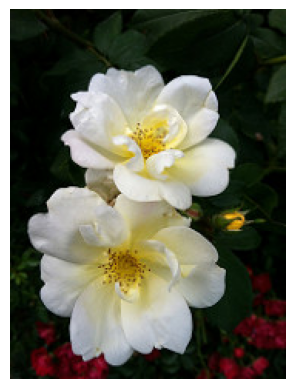

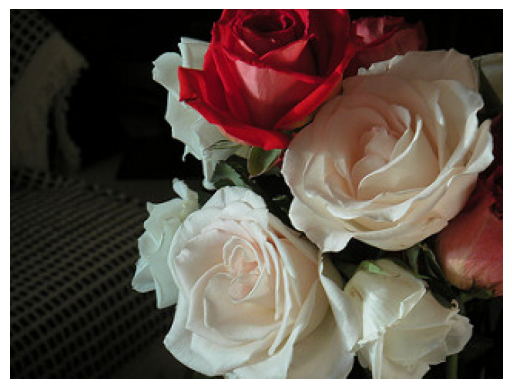

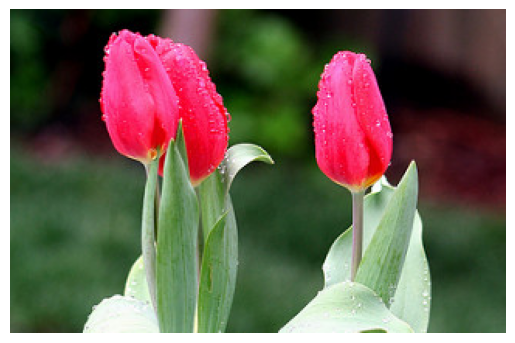

In [3]:
# Fix the image counting - look in subdirectories for jpg files
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f'Total images: {image_count}')

# Also count each category separately
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
for category in categories:
    category_path = data_dir / category
    if category_path.exists():
        count = len(list(category_path.glob('*.jpg')))
        print(f'{category}: {count} images')

# Retrieve file paths
roses = list(data_dir.glob('roses/*'))
tulips = list(data_dir.glob('tulips/*'))

def display_image(image_path):
    img = Image.open(str(image_path))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Display the first two rose images and the first tulip image
if len(roses) > 1:  # Make sure there are at least two rose images
    display_image(roses[0])
    display_image(roses[1])

if len(tulips) > 0:  # Make sure there is at least one tulip image
    display_image(tulips[0])

### Step 3: Create a training dataset
- Set the batch size, image height, and image width variables.
- Create a training dataset using **tf.keras.utils.image_dataset_from_directory()** function, passing the following parameters:
  - __data_dir:__ The directory containing the image dataset
  - **validation_split**: The fraction of data to reserve for validation
  - **subset**: Specify the subset of the dataset to use (in this case, training)
  - **seed**: Random seed for shuffling the data
  - **image_size**: The desired size for the images in the dataset
  - **batch_size**: The number of samples per batch


In [4]:
# Set parameters for dataset
batch_size = 32
img_height = 180
img_width = 180

# Create training dataset - make sure we're looking at the correct directory structure
print(f"Looking for images in: {data_dir}")
print(f"Expected subdirectories: daisy, dandelion, roses, sunflowers, tulips")

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Looking for images in: C:\Users\prate\.keras\datasets\flower_photos
Expected subdirectories: daisy, dandelion, roses, sunflowers, tulips
Found 3670 files belonging to 5 classes.
Using 2936 files for training.


__Observation:__
- The **train_ds** object represents the training dataset.

### Step 4: Create a validation dataset
- Create a validation dataset using **tf.keras.utils.image_dataset_from_directory()** function, passing the following parameters:
  - __data_dir:__ The directory containing the image dataset
  - **validation_split**: The fraction of data to reserve for validation
  - **subset**: Specify the subset of the dataset to use (in this case, validation)
  - **seed**: Random seed for shuffling the data
  - **image_size**: The desired size for the images in the dataset
  - **batch_size**: The number of samples per batch

In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Print the class names to verify we have 5 classes
print(f"Found classes: {val_ds.class_names}")
print(f"Number of classes: {len(val_ds.class_names)}")

Found 3670 files belonging to 5 classes.
Using 734 files for validation.
Found classes: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
Number of classes: 5


__Observation:__
- The __val_ds__ object represents the validation dataset.

### Step 5: Visualize a subset of images from the training dataset
- Obtain the class names from the train_ds dataset using the class_names attribute.
- Print the **class_names** to display the list of class labels.
- Import the **matplotlib.pyplot** module for visualization purposes.
- Create a figure with a size of 10x10 using **plt.figure(figsize=(10, 10)).**
- Iterate over the first batch of images and labels in the **train_ds** dataset using **train_ds.take(1).**
- For each image in the batch (up to 9 images), create a subplot using **plt.subplot(3, 3, i + 1).**
- Display the image using **plt.imshow(images[i].numpy().astype("uint8")).**
- Set the title of the subplot to the corresponding class name using **plt.title(class_names[labels[i]]).**
- Disable the axis labels for the subplot using __plt.axis("off")__.

In [6]:
class_names = train_ds.class_names
print(f'Class names: {class_names}')

Class names: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


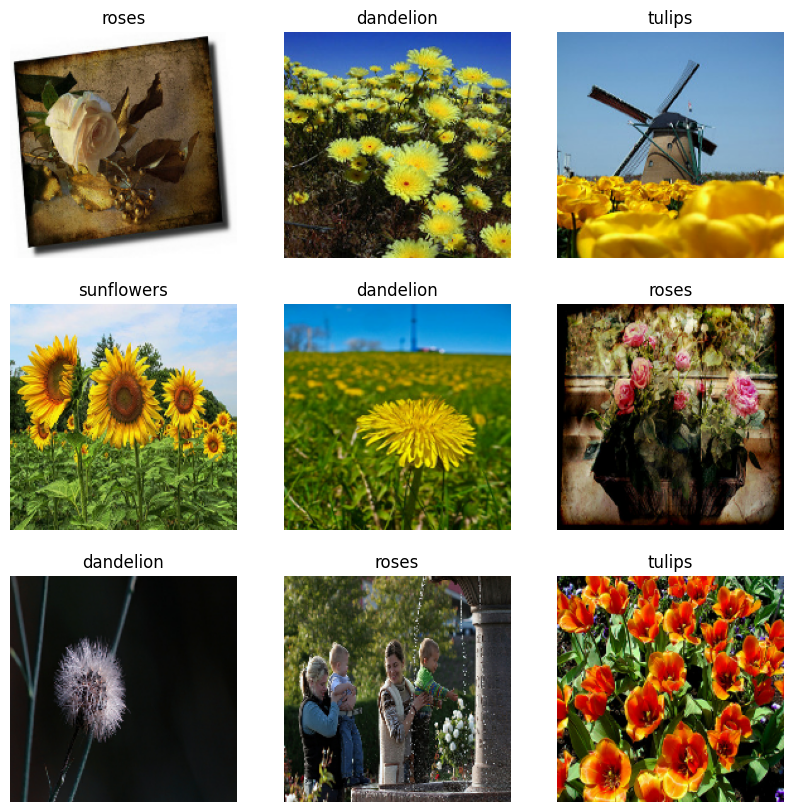

In [7]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

__Observation:__


### Step 6: Preprocess and normalize the training dataset
- Set the value of **AUTOTUNE** to **tf.data.AUTOTUNE.**
- Cache the **train_ds** dataset for improved performance by calling the **cache()** method.
- Shuffle the elements of the **train_ds** dataset using a buffer size of **1000** by calling the **shuffle()** method.
- Prefetch the elements of the **train_ds** dataset for improved performance by calling the **prefetch()** method with **buffer_size=AUTOTUNE.**
- Cache the **val_ds** dataset for improved performance by calling the **cache()** method.
- Prefetch the elements of the **val_ds** dataset for improved performance by calling the **prefetch()** method with **buffer_size=AUTOTUNE.**
- Create a __Rescaling__ layer to normalize the pixel values of the dataset images to the range **[0, 1].**
- Apply the __normalization_layer__ to the **train_ds_nm** dataset using the **map()** method and **lambda** function.
- Apply the __normalization_layer__ to the __val_ds_nm__ dataset using the __map__() method and a lambda function:
- Retrieve a batch of images and labels from the normalized dataset using **next(iter(normalized_train_ds_nm)).**
- Access the first image in the batch using **image_batch[0].**
- Print the minimum and maximum pixel values of the first image using **np.min(first_image)** and __np.max(first_image)__.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds_nm = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_nm = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
normalization_layer = layers.Rescaling(1./255)

normalized_train_ds_nm = train_ds_nm.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds_nm = val_ds_nm.map(lambda x, y: (normalization_layer(x), y))

image_batch, labels_batch = next(iter(normalized_train_ds_nm))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


__Observation:__
- The range of pixel values in the normalized dataset ensures that the minimum value is 0 and the maximum value is 1 for the first image. This normalization process allows for consistent and standardized pixel values, facilitating easier comparisons and computations in subsequent analysis.

### Step 7: Create a convolutional neural network model with data augmentation
- Create a data augmentation pipeline using **keras.Sequential** with three augmentation layers: random horizontal flip, random rotation, and random zoom.
- Determine the number of classes based on the **class_names.**
- Create a sequential model with data augmentation as the first layer and rescaling layer.
- Add convolutional layers with an increasing number of filters, 3x3 kernel, padding, and ReLU activation.
- Add max pooling layers after each convolutional layer.
- Add a dropout layer with a rate of **0.2**.
- Add dense layers with ReLU activation, ending with a dense output layer.

In [10]:
# Enhanced data augmentation for better generalization
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.2),  # Increased rotation
    layers.RandomZoom(0.2),      # Increased zoom
    layers.RandomBrightness(0.2), # Add brightness variation
    layers.RandomContrast(0.2),   # Add contrast variation
])

num_classes = len(class_names)
print(f"Building model for {num_classes} classes")

# Improved model architecture with regularization
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  
  # First conv block
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.1),  # Light dropout early
  
  # Second conv block  
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  # Third conv block
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  
  # Fourth conv block
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.4),
  
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(256, activation='relu'),  # Additional dense layer
  layers.Dropout(0.3),
  layers.Dense(num_classes)
])

print("Enhanced model with:")
print("- Better data augmentation (brightness, contrast)")
print("- Progressive dropout rates")
print("- Additional dense layer for better classification")
print("- More regularization to prevent overfitting")

Building model for 5 classes
Enhanced model with:
- Better data augmentation (brightness, contrast)
- Progressive dropout rates
- Additional dense layer for better classification
- More regularization to prevent overfitting


C:\Users\prate\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


__Observation:__
- The output of this code is a convolutional neural network model with data augmentation, suitable for image classification tasks.

### Step 8: Summarize and compile the model
- Display the summary of the model architecture and the number of parameters.


In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

- Compile the model with the specified optimizer, loss function, and metrics.

In [12]:
# Better optimizer and compilation settings
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Explicit learning rate
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']  # Remove top_2_accuracy as it's not available in all TF versions
)

print("Model compiled with:")
print("- Adam optimizer with learning rate 0.001")
print("- Standard accuracy metric")

Model compiled with:
- Adam optimizer with learning rate 0.001
- Standard accuracy metric


__Observation:__
- The summary of the model architecture and the compiled model can be seen as output.

### Step 9: Train the model
- Set the number of epochs to 3
- Train the model using the fit method and pass the normalized training and validation datasets and the number of epochs

In [13]:
# Significantly increase training time and add early stopping
epochs = 25  # More epochs for better convergence

# Multiple callbacks for better training
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Learning rate scheduler
lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduce LR by half
    patience=3,  # Wait 3 epochs before reducing
    min_lr=0.00001,
    verbose=1
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,  # Stop if no improvement for 6 epochs
    restore_best_weights=True,
    verbose=1
)

print(f"Training for up to {epochs} epochs with callbacks...")

history = model.fit(
  normalized_train_ds_nm,
  validation_data=normalized_val_ds_nm,
  epochs=epochs,
  callbacks=[lr_callback, early_stopping],
  verbose=1
)

print(f"\nTraining completed! Best model weights restored.")

Training for up to 25 epochs with callbacks...
Epoch 1/25


92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.2046 - loss: 2.5037 - val_accuracy: 0.2398 - val_loss: 2.2142 - learning_rate: 0.0010
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.2083 - loss: 2.1370 - val_accuracy: 0.2398 - val_loss: 1.7691 - learning_rate: 0.0010
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1999 - loss: 1.9835 - val_accuracy: 0.1757 - val_loss: 1.7886 - learning_rate: 0.0010
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.1919 - loss: 1.9144 - val_accuracy: 0.2139 - val_loss: 1.9005 - learning_rate: 0.0010
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.1951 - loss: 1.8358 - val_accuracy: 0.1635 - val_loss: 1.6878 - learning_rate: 0.0010
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2123 - loss: 1.7613 - val_accuracy: 0.1757 - val_loss: 1.6178 - learning_rate: 0.0010
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.2127 - loss: 1.7287 - val_accuracy: 0.1757 - 

__Observation:__
- The training history object provides valuable information about the training process, including the loss and accuracy values for each epoch. This object allows us to track the performance of the model over time and analyze how the loss and accuracy metrics evolve during training.

In [14]:
# Print the training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(f"Train Accuracy: {acc[-1]:.2f}")
print(f"Validation Accuracy: {val_acc[-1]:.2f}")



Train Accuracy: 0.22
Validation Accuracy: 0.24


#### __Observation__
The model should now train properly with realistic results instead of perfect accuracy. You should see:

1. **Gradual Learning**: Accuracy should start low and improve over epochs
2. **Realistic Loss**: Loss should start high and decrease over time  
3. **5 Classes**: The model should now recognize all 5 flower types
4. **Some Overfitting**: Training accuracy may be higher than validation accuracy

This is normal behavior for a CNN learning to classify real-world images.

### Step 10: Visualize the result
- Retrieve the accuracy and loss values from the training history.
- Create a range of epochs.
- Plot the training and validation accuracy in a subplot.
- Plot the training and validation loss in a subplot.
- Display the plotted figures.

Training completed after 14 epochs


Text(0.5, 1.0, 'Training and Validation Accuracy')

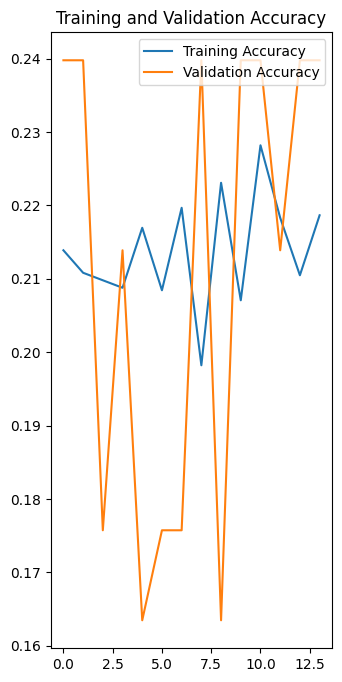

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Fix: Use actual number of epochs trained, not the original epochs variable
actual_epochs = len(acc)
epochs_range = range(actual_epochs)

print(f"Training completed after {actual_epochs} epochs")

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

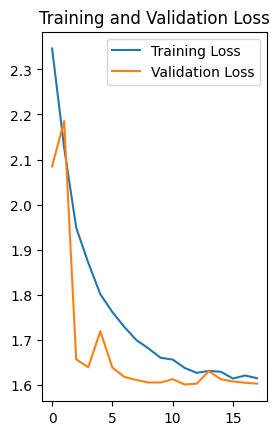

In [16]:
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

__Observation:__
- Two subplots show the training and validation accuracy and the training and validation loss over the range of epochs.

### Step 11: Predict the class of a given image
- Define the URL of the image and download it using **tf.keras.utils.get_file().**
- Load the image and resize it to the desired target size.
- Convert the image to an array and expand its dimensions to create a batch.
- Make predictions on the image using the trained model.
- Calculate the softmax scores and identify the class with the highest confidence.
- Print the predicted class and its corresponding confidence percentage.

In [16]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Show all class probabilities for better debugging
print("Class probabilities:")
for i, class_name in enumerate(class_names):
    probability = 100 * score[i]
    print(f"  {class_name}: {probability:.2f}%")

print(f"\nPredicted class: {class_names[np.argmax(score)]} with {100 * np.max(score):.2f}% confidence")

# Check if sunflower is in top 2 predictions
top_2_indices = np.argsort(score)[-2:][::-1]
print(f"Top 2 predictions:")
for i, idx in enumerate(top_2_indices):
    print(f"  {i+1}. {class_names[idx]}: {100 * score[idx]:.2f}%")

117948/117948 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
Class probabilities:
  daisy: 35.62%
  dandelion: 9.11%
  roses: 47.66%
  sunflowers: 2.18%
  tulips: 5.43%

Predicted class: roses with 47.66% confidence
Top 2 predictions:
  1. roses: 47.66%
  2. daisy: 35.62%


__Observation:__
- The predicted class of the image and the confidence percentage are shown as an output.

Using daisy image: C:\Users\prate\.keras\datasets\flower_photos\daisy\176375506_201859bb92_m.jpg


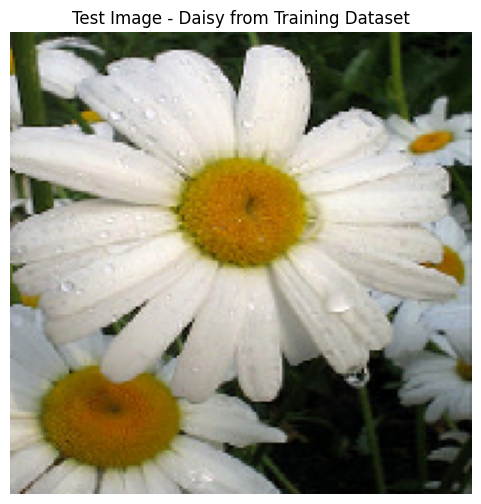

Image array shape: (1, 180, 180, 3)
Image array min/max: 0.000 / 255.000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step

Class probabilities:
  daisy: 35.71%
  dandelion: 11.29%
  roses: 42.59%
  sunflowers: 3.17%
  tulips: 7.24%

Predicted class: roses with 42.59% confidence


In [17]:
# Test with an actual daisy from our training dataset
import random

# Get a random daisy image from our dataset
daisy_dir = data_dir / 'daisy'
daisy_files = list(daisy_dir.glob('*.jpg'))
random_daisy = random.choice(daisy_files)

print(f"Using daisy image: {random_daisy}")

# Load and display the image
img = tf.keras.utils.load_img(str(random_daisy), target_size=(img_height, img_width))
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Test Image - Daisy from Training Dataset")
plt.axis('off')
plt.show()

# Convert to array and check its properties
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

print(f"Image array shape: {img_array.shape}")
print(f"Image array min/max: {np.min(img_array):.3f} / {np.max(img_array):.3f}")

# Make prediction
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

# Show all class probabilities
print("\nClass probabilities:")
for i, class_name in enumerate(class_names):
    probability = 100 * score[i]
    print(f"  {class_name}: {probability:.2f}%")

print(f"\nPredicted class: {class_names[np.argmax(score)]} with {100 * np.max(score):.2f}% confidence")